In [28]:
bucket = 'weteh-sagemaker-examples'
prefix = 'sagemaker/DEMO-linear-mnist'
 
# Define IAM role
import boto3
from sagemaker import get_execution_role

role = "arn:aws:iam::869530972998:role/SagemakerAdmin"

In [29]:
import pickle, gzip, numpy, urllib.request, json

# load MNIST dataset from deepleaerning.net website as pickle format
# https://docs.python.org/3/library/pickle.html
# pickle is a python serder module that serializes/deserializes python data structures between binary form and
# python formats


urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")

# you can use gzip python library to deserialize pickle files
# the output are in the following format and structure:
# train_set: 50000 examples
# test_set: 10000 examples
# validation set: 10000 examples
# data structure: tuple (2 dimensions with features, labels)
# features has ndarray with 784 dimensions (28 x 28), single channel.
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_digit(img, caption='', subplot=None):
    if not subplot:
        _,(subplot)=plt.subplots(1,1) # subplots returns Figure and Axes, we don't care about Figure.
    img = img.reshape((28,28))
    subplot.imshow(img, cmap='gray')
    plt.title(caption)
    


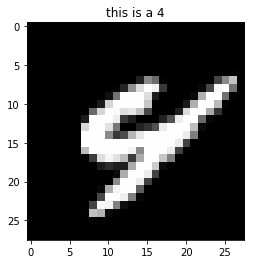

In [32]:
import random
img_idx = random.randrange(0, len(train_set[0]))
show_digit(train_set[0][img_idx], 'this is a {}'.format(train_set[1][img_idx]))

In [52]:
import io
import numpy as np
import sagemaker.amazon.common as smac
import boto3
import os

key = 'recordio-pb-data'

# We need to convert the original pickled array into recordIO so that sagemaker can process the dataset at training time
# not sure if we need to use .tolist() in the list comprehension.
# Basically it's converting a flatten structure with float32 datatypes into recordIO dformat
def write_recordio(data, data_type = 'train'):
    vectors = np.array([t.tolist() for t in data[0]]).astype('float32')

    # In this example, we are only training for binary classification, where if it's 0 then it's a 1, otherwise it's a 0
    labels = np.where(np.array([t.tolist() for t in data[1]]) == 0, 1, 0).astype('float32')

    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, vectors, labels)
    buf.seek(0)
    # for 50k records, the data size is around 151MB    
    boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, data_type, key)).upload_fileobj(buf)
    s3_data = 's3://{}/{}/{}/{}'.format(bucket, prefix, data_type, key)
    print('uploaded {} data location: {}'.format(data_type, s3_data))    
    

In [53]:
write_recordio(train_set, data_type='train')
write_recordio(valid_set, data_type='validation')

uploaded train data location: s3://weteh-sagemaker-examples/sagemaker/DEMO-linear-mnist/train/recordio-pb-data
uploaded validation data location: s3://weteh-sagemaker-examples/sagemaker/DEMO-linear-mnist/validation/recordio-pb-data


In [54]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://weteh-sagemaker-examples/sagemaker/DEMO-linear-mnist/output


In [55]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [56]:
# setup sagemaker session
import boto3
import sagemaker

sess = sagemaker.Session()

#https://sagemaker.readthedocs.io/en/stable/estimators.html
model = sagemaker.estimator.Estimator(container, 
                                      train_instance_type='ml.c4.xlarge',
                                      role=role, 
                                      train_instance_count=1,
                                      sagemaker_session=sess,
                                      output_path=output_location)


In [62]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
model.set_hyperparameters(feature_dim = len(train_set[0][0]),
                          predictor_type='binary_classifier',
                          mini_batch_size=200)

In [63]:
channels = {
    'train': 's3://{}/{}/train/{}'.format(bucket, prefix, key),
    'validation' : 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
}


In [64]:
model.fit(channels)

2019-12-27 18:49:42 Starting - Starting the training job...
2019-12-27 18:49:44 Starting - Launching requested ML instances......
2019-12-27 18:50:51 Starting - Preparing the instances for training......
2019-12-27 18:51:54 Downloading - Downloading input data...
2019-12-27 18:52:42 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[12/27/2019 18:52:46 INFO 140570886870848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr

In [68]:
# save test input as CSV for batch transform
import numpy 
test_vectors = np.array([t.tolist() for t in test_set[0]]).astype('float32')
test_csv_filename = 'test.csv'
numpy.savetxt(test_csv_filename, test_vectors, delimiter=",")


In [71]:
test_s3 = sess.upload_data(test_csv_filename,
                           bucket=bucket,
                           key_prefix='{}/test'.format(prefix))

In [73]:
# define a transformer from the trained model
model_transformer = model.transformer(instance_count=1,
                                  instance_type='ml.m4.xlarge',
                                  strategy='MultiRecord',
                                  assemble_with='Line',
                                  output_path='s3://{}/{}/predictions'.format(bucket, prefix))


In [74]:
model_transformer.transform(test_s3, content_type='text/csv', split_type='Line')
model_transformer.wait()

.....................
Docker entrypoint called with argument(s): serve
[12/27/2019 20:00:06 INFO 140610640557888] loaded entry point class algorithm.serve.server_config:config_api
[12/27/2019 20:00:06 INFO 140610640557888] loading entry points
[12/27/2019 20:00:06 INFO 140610640557888] loaded request iterator text/csv
[12/27/2019 20:00:06 INFO 140610640557888] loaded request iterator application/x-recordio-protobuf
[12/27/2019 20:00:06 INFO 140610640557888] loaded request iterator application/json
[12/27/2019 20:00:06 INFO 140610640557888] loaded request iterator application/jsonlines
[12/27/2019 20:00:06 INFO 140610640557888] loaded response encoder text/csv
[12/27/2019 20:00:06 INFO 140610640557888] loaded response encoder application/x-recordio-protobuf
[12/27/2019 20:00:06 INFO 140610640557888] loaded response encoder application/json
[12/27/2019 20:00:06 INFO 140610640557888] loaded response encoder application/jsonlines
[12/27/2019 20:00:06 INFO 140610640557888] loaded entry poin

In [98]:
import io
import pandas as pd
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key='{}/predictions/{}.out'.format(prefix, test_csv_filename))
df = pd.read_json(io.BytesIO(obj['Body'].read()), lines=True)

In [106]:
import json
predictions = df['predicted_label'].to_numpy()
true_test_labels = np.where(test_set[1] == 0, 1, 0)
pd.crosstab(true_test_labels, predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0,1
actuals,,
0,8980,40
1,38,942


In [105]:
!pip install pandas_ml

    100% |████████████████████████████████| 102kB 34.1MB/s a 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [108]:
from pandas_ml import ConfusionMatrix
confusion_matrix = ConfusionMatrix(true_test_labels, predictions)

In [109]:
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       8980    40     9020
True          38   942      980
__all__     9018   982    10000


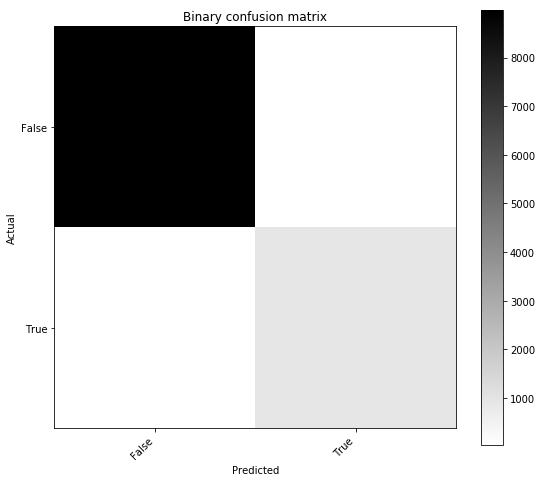

In [112]:
#confusion_matrix.plot(normalized=True)
confusion_matrix.plot()
plt.show()